In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cpnDISORTlib import *
from cpnRetrievalslib import Bispec_LUT
import cpnCommonlib as cpn

## Previous LUTs

In [2]:
SZA=120
LUT=Bispec_LUT('/umbc/xfs1/zzbatmos/users/charaj1/LES_MSCART_retrievals/LUTs/',\
                   'MODIS_LUT_extended_SZA%03d_RAA000.nc'%(180-int(SZA)))
LUT.readLUT()

In [54]:
LUT.I.shape

(3, 101, 11, 57, 300)

In [62]:
LUT.band[0],LUT.tau[57],LUT.ve[4],LUT.re[20]

(0.86, 5.12861, 0.05, 12.0)

Text(0.5, 0, 'VZA')

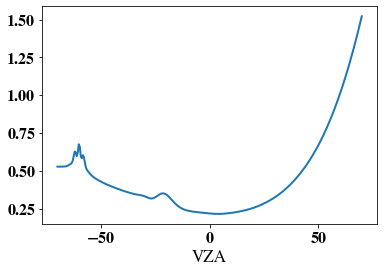

In [141]:
plt.plot(np.hstack((np.ones(150),np.ones(150)*-1))*np.rad2deg(np.arccos(LUT.mu)),LUT.I[0,57,4,21,:])
plt.xlabel('VZA')

#### Testing scattering angle computation

In [73]:
"phi=%f,mu0=%f"%(LUT.phi,LUT.mu0)

'phi=0.000000,mu0=0.500000'

In [95]:
vza=np.rad2deg(np.arccos(LUT.mu))
sza=np.rad2deg(np.arccos(LUT.mu0))
RAA = np.zeros(300,dtype=float)
RAA[150:]=180

In [96]:
sa=scat_ang(180-sza,vza,RAA)

Text(0.5, 0, 'Scattering Angle')

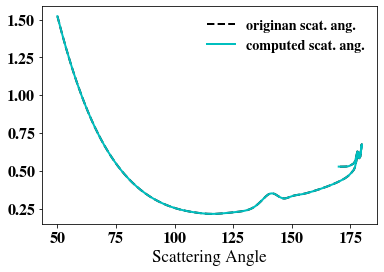

In [140]:
plt.plot(LUT.scat,LUT.I[0,57,4,21,:],'k--',label='originan scat. ang.')
plt.plot(sa,LUT.I[0,57,4,21,:],'c',label='computed scat. ang.')
plt.legend()
plt.xlabel('Scattering Angle')

## From DISOROT

- Note that the correc CER has not been used yet.

In [3]:
I,SZA,SAA,VZA,VAA,ScatA=read_disort()

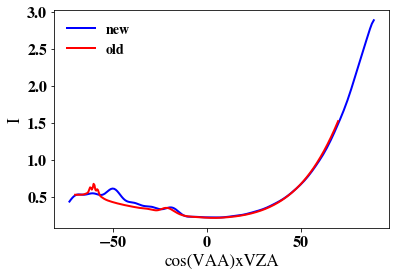

In [19]:
plt.plot(np.cos(np.rad2deg(VAA))*VZA,np.pi*I/np.cos(np.deg2rad(SZA)),'b',label='new')
plt.plot(np.hstack((np.ones(150),np.ones(150)*-1))*np.rad2deg(np.arccos(LUT.mu)),LUT.I[0,57,4,21,:],'r',label='old')
plt.xlabel('cos(VAA)xVZA')
plt.ylabel('I')
plt.legend()

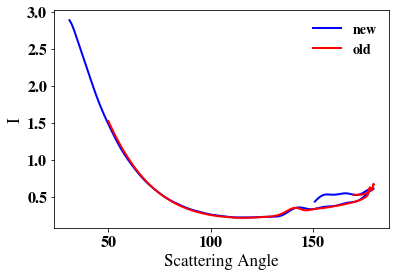

In [18]:
plt.plot(ScatA,np.pi*I/np.cos(np.deg2rad(SZA)),'b',label='new')
plt.plot(LUT.scat,LUT.I[0,57,4,21,:],'r',label='old')
plt.xlabel('Scattering Angle')
plt.ylabel('I')
plt.legend()